# 1. Extraire les probabilités de défaut implicites


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.stats as stats
from scipy.stats import binom, norm, skew, kurtosis, t, beta
from scipy.optimize import minimize

In [2]:
def pd_from_cds(spread_bp, maturity, recovery=0.40):
    """ 
    Fonction pour extraire les probabilité de défaut implicite
    """
    # Conversion bp -> décimal (1bp = 0.0001)
    spread = spread_bp / 10000  
    lambda_ = spread / (1 - recovery)
    pd = 1 - np.exp(-lambda_ * maturity)
    return pd

In [3]:
# Pour BNP
pd_bnp_4y = pd_from_cds(100, 4)
pd_bnp_5y = pd_from_cds(120, 5)

# Pour SG
pd_sg_4y = pd_from_cds(120, 4)
pd_sg_5y = pd_from_cds(150, 5)

print("PD BNP 4 ans :", pd_bnp_4y)
print("PD BNP 5 ans :", pd_bnp_5y)
print("PD SG 4 ans :", pd_sg_4y)
print("PD SG 5 ans :", pd_sg_5y)


PD BNP 4 ans : 0.06449301496838222
PD BNP 5 ans : 0.09516258196404048
PD SG 4 ans : 0.07688365361336424
PD SG 5 ans : 0.11750309741540454


# 2. Caractériser les distributions des taux de recouvrement de chacune des deux créances

In [4]:
# Pour carctériser les distributions des taux de recouvrement, on suppose que les recouvrement 
# suivent une loi Beta
# On déduit les paramètres à partir de la moyenne et de la volatilité

def beta_params(mean, vol):
    """  
    Fonction qui retourne les paramètres de la loi Beta à partir de la moyenne et de la volatilité
    """
    a_chapeau = (mean**2 * (1 - mean))/(vol**2) - mean
    b_chapeau = (mean**2 * (1 - mean)**2)/(mean * vol**2) - (1- mean)

    return a_chapeau, b_chapeau


In [5]:
# Pour BNP (moyenne 60 %, vol 15 %)
mean_bnp = 0.60
vol_bnp = 0.15
a_chapeau_bnp, b_chapeau_bnp = beta_params(mean_bnp, vol_bnp)

# Pour SG (moyenne 30 %, vol 25 %)
mean_sg = 0.30
vol_sg = 0.25
a_chapeau_sg, b_chapeau_sg= beta_params(mean_sg, vol_sg)

print("BNP Beta parameters: alpha =", a_chapeau_bnp, "beta =", b_chapeau_bnp)
print("SG Beta parameters: alpha =", a_chapeau_sg, "beta =", b_chapeau_sg)

BNP Beta parameters: alpha = 5.8 beta = 3.8666666666666676
SG Beta parameters: alpha = 0.708 beta = 1.652


## Interpétation :
  - ## Pour BNP : a > b donc asymétrie à droite
  - ## Pur SG : a < b  donc asymétrie à gauche ?

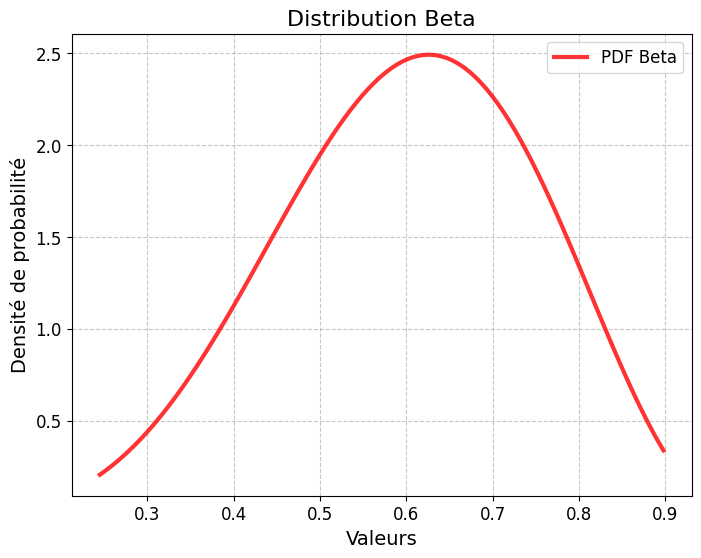

In [18]:
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt

def plot_beta_distribution(a_chapeau, b_chapeau):
    """
    Affiche un graphique de la distribution Beta avec les paramètres donnés.

    Paramètres :
    a_chapeau : float : paramètre alpha de la distribution Beta
    b_chapeau : float : paramètre beta de la distribution Beta
    """
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    x = np.linspace(beta.ppf(0.01, a_chapeau, b_chapeau),
                    beta.ppf(0.99, a_chapeau, b_chapeau), 100)
    y = beta.pdf(x, a_chapeau, b_chapeau)

    ax.plot(x, y, 'r-', lw=3, alpha=0.8, label='PDF Beta')

    ax.set_title('Distribution Beta', fontsize=16)
    ax.set_xlabel('Valeurs', fontsize=14)
    ax.set_ylabel('Densité de probabilité', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(loc='best', fontsize=12)

    plt.show()

plot_beta_distribution(a_chapeau_bnp, b_chapeau_bnp)

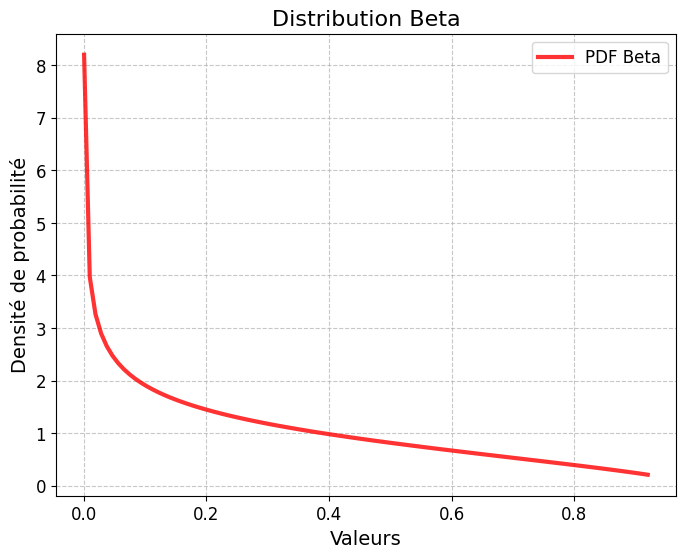

In [15]:
plot_beta_distribution(a_chapeau_sg, b_chapeau_sg)

# 3. On s’intéresse à l’historique des données actions. 
## 3.a. Effectuer une analyse exploratoire univariée des données actions de ces deux entreprises

In [19]:
# Chargement des données
data = pd.read_csv("data.txt", sep="\s+", header=0)
data.head()

,BNP,SG
0,42.36,55.24
1,42.72,55.59
2,43.20,56.45
3,42.67,55.55
4,41.81,54.50


In [29]:
data.describe()

,BNP,SG
count,1000.000000,1000.000000
mean,31.906254,43.532641
std,9.630129,10.007847
min,14.056200,21.667700
25%,23.450325,36.065350
50%,34.353700,46.824800
75%,40.229375,51.291675
max,48.330000,60.680000


In [35]:
data_returns = np.log(data/data.shift(1)).dropna()
data_returns.head(3)

,BNP,SG
1,0.008463,0.006316
2,0.011173,0.015352
3,-0.012344,-0.016072


In [28]:
data_returns.describe()

,BNP,SG
count,999.000000,999.000000
mean,-0.000888,-0.000687
std,0.024441,0.020731
min,-0.123524,-0.098292
25%,-0.013867,-0.011830
50%,-0.000358,-0.000547
75%,0.012526,0.011223
max,0.083225,0.076478


In [54]:
from scipy.stats import shapiro
from statsmodels.tsa.stattools import adfuller

def analyze_data(df, name="Dataset"):
    """
    Analyse les données du DataFrame fourni et retourne un DataFrame avec :
    - Statistiques descriptives
    - Tests de normalité (Shapiro-Wilk)
    - Tests de stationnarité (Dickey-Fuller)

    Paramètres :
    df : DataFrame : Doit contenir les colonnes 'Close' et 'Rendement'
    name : str : Nom du dataset (optionnel)

    Retourne :
    results : DataFrame avec toutes les analyses
    """
    # Vérification de la présence des colonnes nécessaires
    if not {'Close', 'Rendement'}.issubset(df.columns):
        raise ValueError("Le DataFrame doit contenir les colonnes 'Close' et 'Rendement'.")

    # Statistiques descriptives
    results = df[['Close', 'Rendement']].describe()
    results['Indicateur'] = ["Nombre", "Moyenne", "Ecart-Type", "Minimum", "Percentile 25%", "Médiane", "Percentile 75%", "Maximum"]
    results = results[['Indicateur', 'Close', 'Rendement']]

    # Test de normalité (Shapiro-Wilk)
    _, p_rend = shapiro(df['Rendement'].dropna())
    _, p_close = shapiro(df['Close'].dropna())
    results = pd.concat([results, pd.DataFrame([["Normalité (p)", p_close, p_rend]], columns=results.columns)])

    # Test de stationnarité (Dickey-Fuller)
    _, p_value_rend = adfuller(df['Rendement'].dropna())[:2]
    _, p_value_close = adfuller(df['Close'].dropna())[:2]
    results = pd.concat([results, pd.DataFrame([["Stationnarité (p)", p_value_close, p_value_rend]], columns=results.columns)])

    return results

data_bnp = pd.concat([data["BNP"], data_returns["BNP"]], axis=1)
data_bnp.columns = ['Close', 'Rendement']  # Renommage des colonnes

analyze_data(data_bnp)

,Indicateur,Close,Rendement
count,Nombre,1.000000e+03,9.990000e+02
mean,Moyenne,3.190625e+01,-8.875748e-04
std,Ecart-Type,9.630129e+00,2.444100e-02
min,Minimum,1.405620e+01,-1.235235e-01
25%,Percentile 25%,2.345032e+01,-1.386684e-02
50%,Médiane,3.435370e+01,-3.578458e-04
75%,Percentile 75%,4.022938e+01,1.252624e-02
max,Maximum,4.833000e+01,8.322452e-02
0,Normalité (p),2.361886e-21,7.315078e-12
0,Stationnarité (p),7.943908e-01,0.000000e+00


In [ ]:
data_sg = pd.concat([data["SG"], data_returns["SG"]], axis=1)
data_sg.columns = ['Close', 'Rendement']  # Renommage des colonnes

analyze_data(data_sg)

,Indicateur,Close,Rendement
count,Nombre,1.000000e+03,9.990000e+02
mean,Moyenne,4.353264e+01,-6.874575e-04
std,Ecart-Type,1.000785e+01,2.073120e-02
min,Minimum,2.166770e+01,-9.829201e-02
25%,Percentile 25%,3.606535e+01,-1.182979e-02
50%,Médiane,4.682480e+01,-5.468895e-04
75%,Percentile 75%,5.129167e+01,1.122288e-02
max,Maximum,6.068000e+01,7.647830e-02
0,Normalité (p),2.019151e-20,4.726505e-12
0,Stationnarité (p),7.361591e-01,8.678531e-09


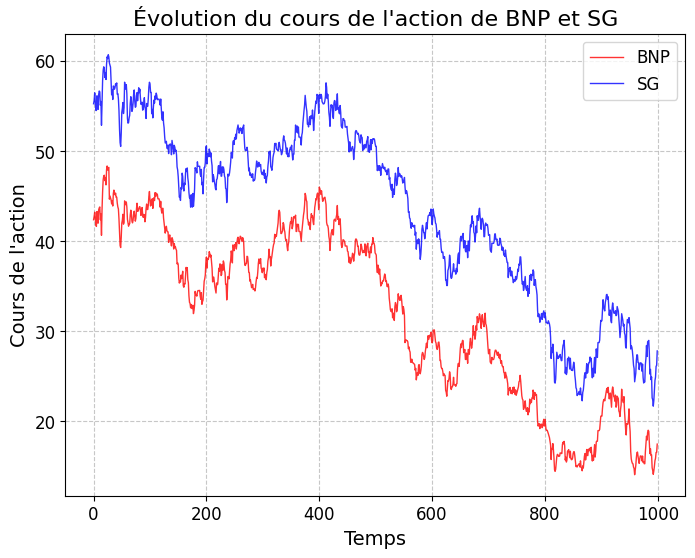

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(data["BNP"], 'r-', lw=1, alpha=0.8, label='BNP')
ax.plot(data["SG"], 'b-', lw=1, alpha=0.8, label='SG')
ax.set_title("Évolution du cours de l'action de BNP et SG", fontsize=16)
ax.set_xlabel('Temps', fontsize=14)
ax.set_ylabel("Cours de l'action", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(loc='best', fontsize=12)
plt.show()

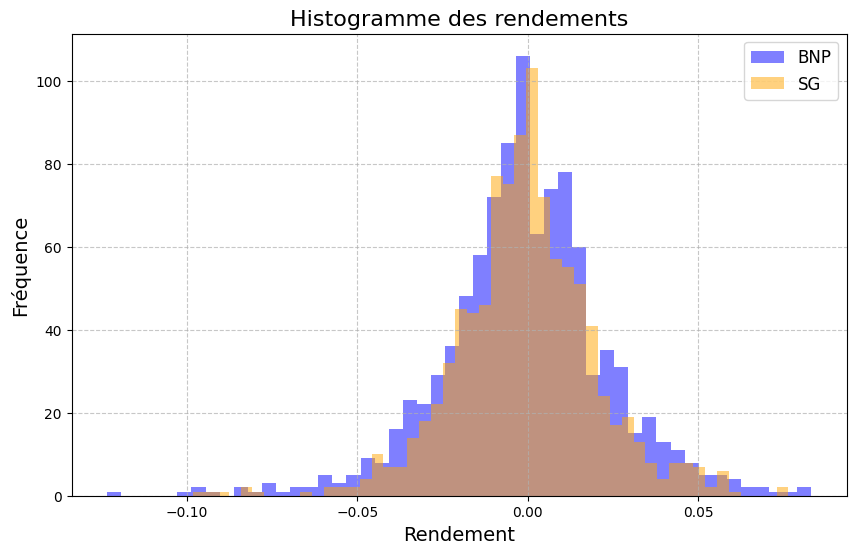

In [62]:
# Création de la figure et des axes
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
# Création de l'histogramme
ax.hist(data_returns['BNP'], bins=50, alpha=0.5, label="BNP", color='blue')
ax.hist(data_returns['SG'], bins=50, alpha=0.5, label="SG", color='orange')
# Ajout du titre et des légendes
ax.set_title("Histogramme des rendements", fontsize=16)
ax.set_xlabel("Rendement", fontsize=14)
ax.set_ylabel("Fréquence", fontsize=14)
ax.legend(loc='upper right', fontsize=12)
# Personnalisation de la grille
ax.grid(True, linestyle='--', alpha=0.7)
# Affichage du graphique
plt.show()

## 3.b Modéliser judicieusement les distributions univariées des facteurs de risques

In [ ]:
def skew_t_pdf(x, params):
    """
    Densité de probabilité de la loi Skew Student.

    Paramètres :
    - x : Valeurs pour lesquelles calculer la densité.
    - mu : Moyenne de la distribution.
    - nu : Degrés de liberté de la loi t.
    - sigma : Écart-type de la distribution.
    - gamma : Paramètre de skewness (asymétrie).

    Retour :
    - La densité de probabilité pour chaque valeur de x.
    """
    mu, nu, sigma, gamma = params
    # Calcul de la densité de la loi Student standard avec nu degrés de liberté
    z = (x - mu) / sigma
    student_pdf = t.pdf(x, df=nu, loc = mu, scale=sigma)

    # Calcul de la CDF de la Student avec (nu + 1) degrés de liberté, et ajustement avec gamma
    student_cdf = t.cdf(gamma*z*np.sqrt((nu+1)/(z**2 + nu)), df=nu + 1)

    # Retour de la densité de la Skew-Student avec facteur d'asymétrie
    return 2 * student_pdf * student_cdf

In [ ]:
def neg_log_likelihood(params, x):
    """Log-vraisemblance négative à minimiser"""
    mu, nu, sigma, gamma = params

    return -np.sum(np.log(np.maximum(skew_t_pdf(x, params), 10e-10)))

In [ ]:
def estimate_skew_t_params(x):
    """Estimation des paramètres par maximum de vraisemblance"""
    init_params = [0, 2, 0.1, 0]  # Initialisation
    bounds = [(0, None), (2, None), (10e-6, None), (-1, 1)]

    result = minimize(neg_log_likelihood, init_params, args=(x,), bounds=bounds, method='L-BFGS-B')

    if result.success:
        return result.x
    else:
        raise ValueError("L'optimisation a échoué.")

In [ ]:
mu_bnp, nu_bnp, sigma_bnp, gamma_bnp = estimate_skew_t_params(data_returns["BNP"].dropna())
print(f"Paramètres estimés pour BNP: mu = {mu_bnp:.4f}, nu = {nu_bnp:.4f}, sigma = {sigma_bnp:.4f}, gamma = {gamma_bnp:.4f}")

Paramètres estimés pour BNP: mu = 0.0020, nu = 4.5876, sigma = 0.0189, gamma = -0.1523


In [ ]:
mu_sg, nu_sg, sigma_sg, gamma_sg = estimate_skew_t_params(data_returns["SG"].dropna())
print(f"Paramètres estimés pour SG : mu = {mu_sg:.4f}, nu = {nu_sg:.4f}, sigma = {sigma_sg:.4f}, gamma = {gamma_sg:.4f}")

Paramètres estimés pour SG : mu = 0.0000, nu = 4.6121, sigma = 0.0159, gamma = -0.0466


In [ ]:
def skew_student_quantile(params, prob, size=100000):
    """
    Génère des observations selon une loi Skew Student et renvoie le quantile correspondant à prob.

    Paramètres :
    - mu : moyenne
    - nu : degré de liberté de la Student
    - sigma : écart-type
    - gamma : paramètre de biais
    - prob : probabilité pour le quantile
    - size : nombre d'observations générées (par défaut 100000)

    Retourne :
    - Le quantile correspondant à la probabilité donnée
    """
    mu, nu, sigma, gamma = params
    T_g1 = stats.t.rvs(df=nu, size=size)
    T_g2 = stats.t.rvs(df=nu, size=size)

    Z = mu + sigma / np.sqrt(1 + gamma**2) * (gamma * T_g1 + T_g2)

    return np.percentile(Z, 100 * (prob))

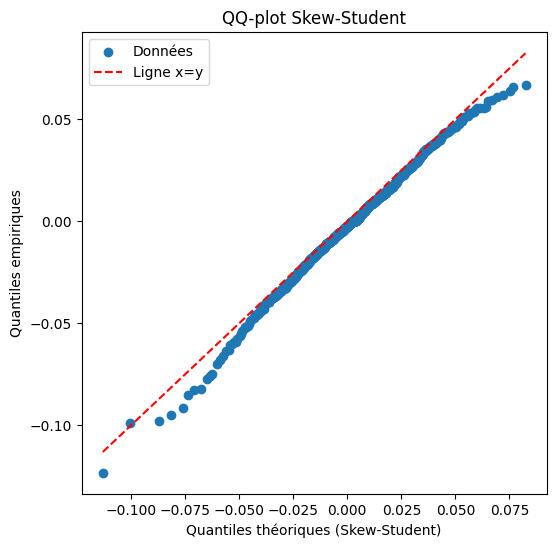

In [ ]:
# c. QQ-plot pour validation ex-ante
#mu, nu, sigma, gamma = params
#optim_ppf = [(ppf_skew_t(p/n, (mu, nu, sigma, gamma)), sorted_x[p-1]) for p in range(1, n+1) if ppf_skew_t(p/n, (mu, nu, sigma, gamma)) != None]

#theoretical_quantiles = np.array(optim_ppf)[:,0]
#sorted_x = np.array(optim_ppf)[:,1]

def qq_plot(x, params):
    """QQ-plot pour comparer les quantiles empiriques et théoriques d'une loi Skew-Student."""
    sorted_x = np.sort(x)
    n = len(x)
    theoretical_quantiles = [skew_student_quantile(params, p/n) for p in range(1, n+1)]
    theoretical_quantiles = np.array(theoretical_quantiles)
    sorted_x = np.array(sorted_x)

    theoretical_quantiles = theoretical_quantiles[theoretical_quantiles<max(sorted_x)]
    plt.figure(figsize=(6,6))
    plt.scatter(theoretical_quantiles, sorted_x[:len(theoretical_quantiles)], label="Données")
    plt.plot(theoretical_quantiles, theoretical_quantiles, 'r--', label="Ligne x=y")
    plt.xlabel("Quantiles théoriques (Skew-Student)")
    plt.ylabel("Quantiles empiriques")
    plt.legend()
    plt.title("QQ-plot Skew-Student")
    plt.show()

qq_plot(data_returns["BNP"].dropna(), (mu_bnp, nu_bnp, sigma_bnp, gamma_bnp))

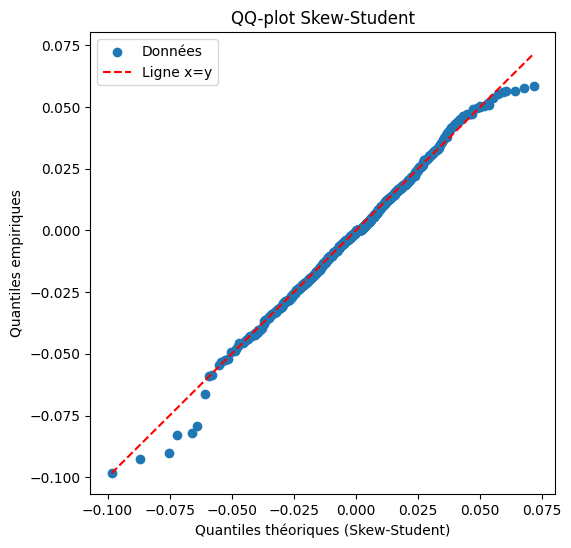

In [ ]:
qq_plot(data_returns["SG"].dropna(), (mu_sg, nu_sg, sigma_sg, gamma_sg))

In [ ]:
# e. Calcul de la VaR Skew-Student à 99%
def var_skew_t(alpha, params):
    """Calcul de la VaR à alpha% pour une loi Skew-Student."""
    return skew_student_quantile(params, 1 - alpha)

var_99_bnp = var_skew_t(0.99, (mu_bnp, nu_bnp, sigma_bnp, gamma_bnp))
var_99_sg = var_skew_t(0.99, (mu_sg, nu_sg, sigma_sg, gamma_sg))
print(f"VaR Skew-Student à 99% de bnp : {var_99_bnp:.4f}")
print(f"VaR Skew-Student à 99% de sg : {var_99_sg:.4f}")

VaR Skew-Student à 99% de bnp : -0.0639
VaR Skew-Student à 99% de sg : -0.0553


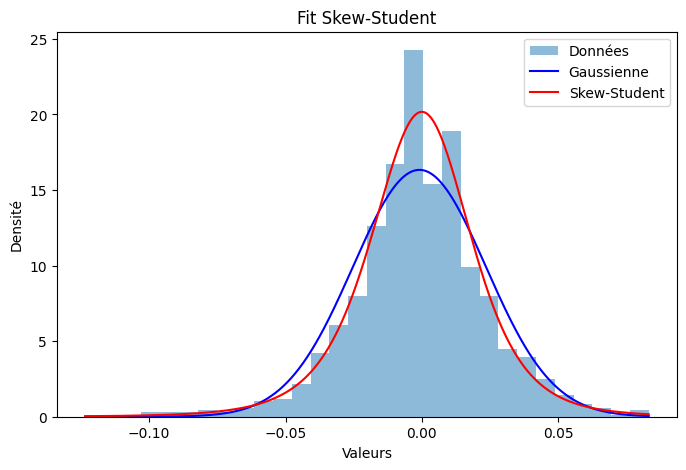

In [ ]:
# d. Comparaison des fits
def plot_fit_comparison(x, params_skew_t):
    """Comparaison des fits entre la loi gaussienne et la loi Skew-Student."""
    plt.figure(figsize=(8,5))

    # Histogramme des données
    plt.hist(x, bins=30, density=True, alpha=0.5, label="Données")

    # Densité gaussienne
    mu_norm, sigma_norm = np.mean(x), np.std(x)
    x_vals = np.linspace(min(x), max(x), 1000)
    plt.plot(x_vals, stats.norm.pdf(x_vals, mu_norm, sigma_norm), label="Gaussienne", color='blue')

    # Densité Skew-Student
    plt.plot(x_vals, skew_t_pdf(x_vals, params_skew_t), label="Skew-Student", color='red')

    plt.xlabel("Valeurs")
    plt.ylabel("Densité")
    plt.legend()
    plt.title("Fit Skew-Student")
    plt.show()

plot_fit_comparison(data_returns["BNP"].dropna(), (mu_bnp, nu_bnp, sigma_bnp, gamma_bnp))

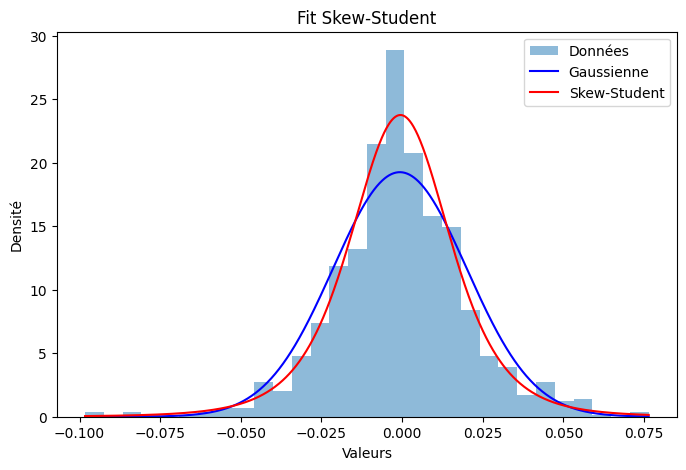

In [ ]:
plot_fit_comparison(data_returns["SG"].dropna(), (mu_sg, nu_sg, sigma_sg, gamma_sg))

### Normale Inverse Gaussienne

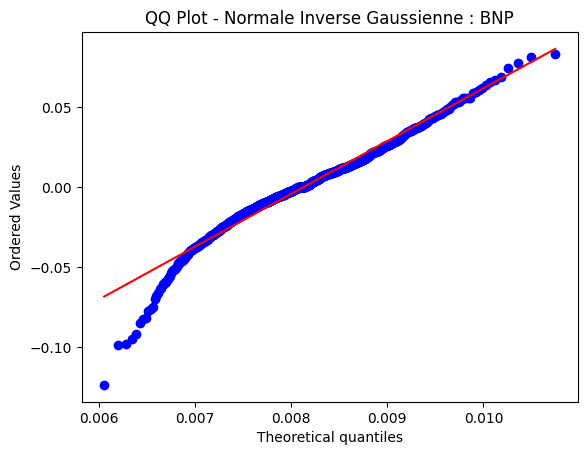

In [ ]:
# Ajustement de la distribution normale inverse gaussienne
params_bnp = stats.invgauss.fit(data_returns["BNP"])

# Tracé du QQ plot
fig, ax = plt.subplots()
stats.probplot(data_returns["BNP"], dist="invgauss", sparams=params_bnp[:-2], plot=ax)
ax.set_title('QQ Plot - Normale Inverse Gaussienne : BNP')
plt.show()

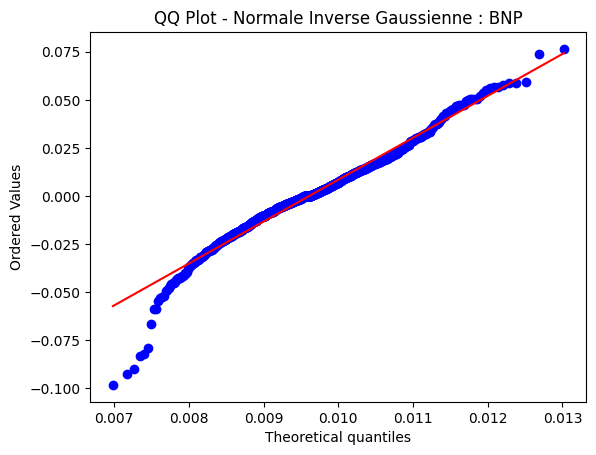

In [ ]:
# Ajustement de la distribution normale inverse gaussienne
params_sg = stats.invgauss.fit(data_returns["SG"])

# Tracé du QQ plot
fig, ax = plt.subplots()
stats.probplot(data_returns["SG"], dist="invgauss", sparams=params_sg[:-2], plot=ax)
ax.set_title('QQ Plot - Normale Inverse Gaussienne : BNP')
plt.show()

Corrélation de Pearson :
           BNP        SG
BNP  1.000000  0.863498
SG   0.863498  1.000000
Corrélation de Spearman :
           BNP        SG
BNP  1.000000  0.840957
SG   0.840957  1.000000
Corrélation de Kendall :
           BNP        SG
BNP  1.000000  0.669096
SG   0.669096  1.000000


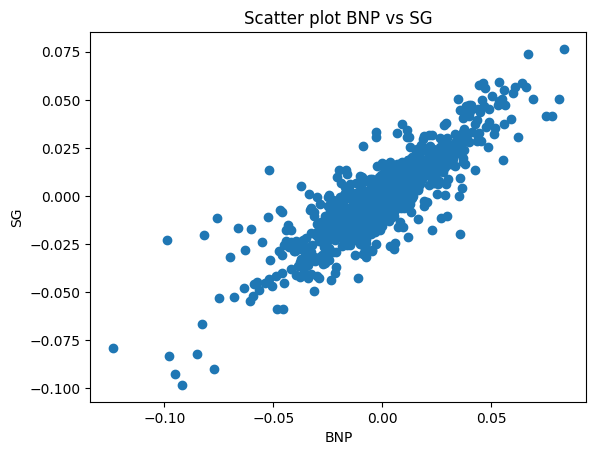

In [ ]:
# Calcul des corrélations
print("Corrélation de Pearson :\n", data_returns.corr(method="pearson"))
print("Corrélation de Spearman :\n", data_returns.corr(method="spearman"))
print("Corrélation de Kendall :\n", data_returns.corr(method="kendall"))

# Nuage de points
plt.scatter(data_returns['BNP'], data_returns['SG'])
plt.xlabel("BNP")
plt.ylabel("SG")
plt.title("Scatter plot BNP vs SG")
plt.show()

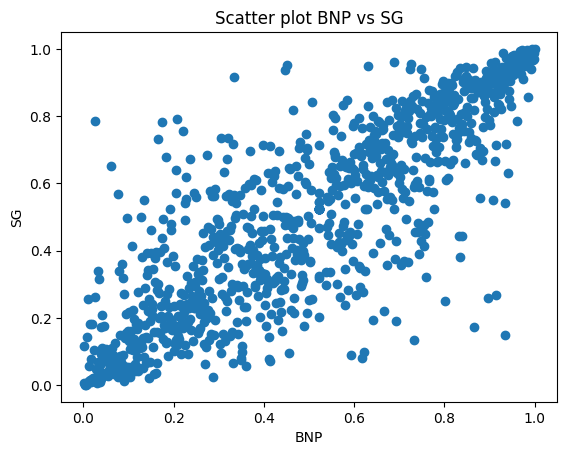

In [ ]:
data_uniform = data_returns.rank(method='average', pct=True)
# Nuage de points
plt.scatter(data_uniform['BNP'], data_uniform['SG'])
plt.xlabel("BNP")
plt.ylabel("SG")
plt.title("Scatter plot BNP vs SG")
plt.show()


# 5. Modéliser la structure de dépendance au moyen des copules paramétriques suivantes :

## 5.a. Copules elliptiques : gaussienne, Student. 

In [ ]:
from copulas.visualization import scatter_3d
from copulas.multivariate import GaussianMultivariate

# Transformation en uniforms via les rangs (méthode empirique)
data_uniform = data_returns.rank(method='average', pct=True)

# Ajustement de la copule gaussienne sur les données brutes
gaussian_copula = GaussianMultivariate()
gaussian_copula.fit(data_returns)
# Génération d'échantillons
samples = gaussian_copula.sample(1000)

compare_3d(data_returns, sampled)

1      0.008463
2      0.011173
3     -0.012344
4     -0.020361
5     -0.004555
         ...   
995    0.040098
996    0.016663
997    0.039914
998    0.001131
999    0.053488
Name: BNP, Length: 999, dtype: float64

# 5. Modéliser la structure de dépendance au moyen des copules paramétriques suivantes : 

## Copules elliptiques : gaussienne, Student.